Here, we will do the aperture photometry on hubble images-.

Belowes are skeleton (with a bit of muscle) code to do that. 
I mark the part you have to fill to complete the code.
Write down your code to reffering the annotation and class material.
For each code you write, add an annotation describing what your code do and what the reason/purpoose of your code is.

If you correctly write the code, you will get the CMD of .
Based on the CMD you get, answer following questions.

1. What do you see from the CMD?
2. What can you know from them?

# 

# 1. Aperture photometry for hubble images

In [2]:
# Import packagaes

# Basic packages
import numpy as np
import copy

# For plotting
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# To read fits file
from astropy.nddata import CCDData, Cutout2D

# For numerical calculationp
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting

# For aperture photometry
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

In [3]:
# Setting matplotlib parameters
# You don't need to change this cell unless you want to change plotting styles.

plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = 'cm'
# plt.rcParams['figure.figsize']=[4,3.5]
plt.rcParams['font.size']=20
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True

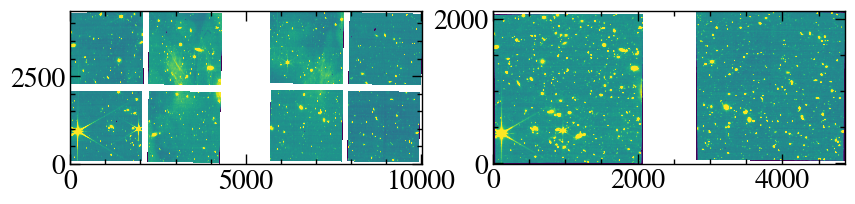

In [5]:
# Read fits data
f150w = CCDData.read('f150w.fits', hdu=0, unit='MJy/sr  ')
f360m = CCDData.read('f360m.fits', hdu=0, unit='MJy/sr  ')
#######################################################################
# Save fits data in the list
data = [f150w, f360m]

# Plot the orginal image
# You may not need to change below
fig, ax = plt.subplots(1, 2, figsize=(5*2, 10))
for i, dat in enumerate(data):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')

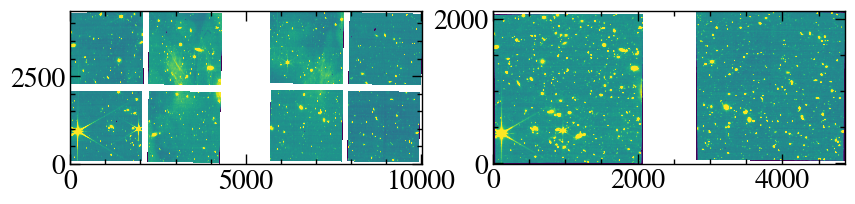

In [6]:
mask_f150w, mask_360m = np.zeros_like(data[0]).astype(bool), np.zeros_like(data[1]).astype(bool) # zero arrays with the same sizes of original images.

# Set values in the area you want to mask as Trues
########################write your code################################
mask_f150w[0:1,0:1] = True
mask_360m[0:1,0:1] = True
#######################################################################

# Save the mask arrays in the list
mask = [mask_f150w, mask_360m]

# Plot the masked image
# You may not need to change below
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas) in enumerate(zip(data, mask)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')


 id      xcentroid      ...        flux                mag         
---- ------------------ ... ------------------ --------------------
   1   4237.85949421832 ... 3.0003514649122454  -1.1929303287420263
   2 3577.8625557453747 ... 2.1927168570089233  -0.8524563883848766
   3    9909.5530339183 ... 3.1741485351666996   -1.254068114564644
 ...                ... ...                ...                  ...
8994  7430.487476604524 ... 1.8347278010483716  -0.6589291043430913
8995  6033.459429628008 ... 1.0690262721523114 -0.07247094616173089
8996  5689.085358332114 ... 2.6447175576784216  -1.0559482460401262
Length = 8996 rows



 id      xcentroid      ...        flux                mag        
---- ------------------ ... ------------------ -------------------
   1 2046.1819739794241 ... 2.8604798634476114 -1.1410972371635266
   2 2014.7194599672289 ... 3.0584849171847455 -1.2137658578262662
   3 1784.6142433520224 ...  2.879517625694596 -1.1482993530395091
 ...                ... ...                ...                 ...
9303  3081.829820060981 ...  4.753183560293427 -1.6924614659300363
9304 2795.6660697695365 ... 3.9691066141806393 -1.4967319116219526
9305 2951.0558556671945 ...  4.824796267768545 -1.7086974487840065
Length = 9305 rows


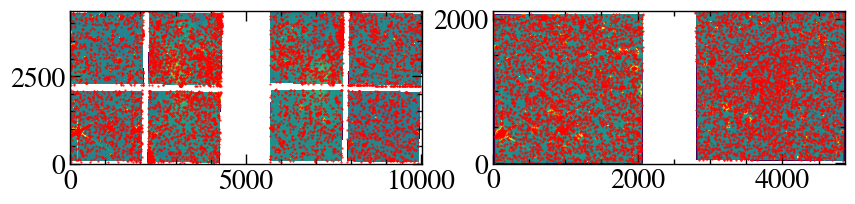

In [8]:
pos = [] # list to save the positions of detected stars in each image

# parameter settings
# Here we use the threshold = 5 times the standard deviation of the image, fwhm=2
thres = 5 # pixel value above which, when multiplied by sigma, pixels are considered to be stars.
fwhm = 4 # minimum radius over which objects are considered to be stars.

for dat, mas in zip(data, mask):
    # Detect stars
    ########################write your code################################
    avg, med, std = sigma_clipped_stats(dat.data) # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
    finder = DAOStarFinder(threshold=thres*std, fwhm=fwhm, exclude_border=True)
    sources = finder(dat.data - med, mask=mas)
    print()
    #######################################################################
    sources.pprint(max_lines=10)
    pos.append(np.transpose((sources['xcentroid'], sources['ycentroid']))) # save the position of the stars

# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas) in enumerate(zip(data, mask)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    # dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].plot(pos[i][:,0], pos[i][:,1], 'ro', markersize=0.5)

In [ ]:
# Set apertures
apertures = [CircularAperture(pos[0], r=2*4), CircularAperture(pos[1], r=2*4)] # Here, we define the aperture with the radius of 4 times FWHM
sum_stars = [] # list to save the sum of pixel values of each star

for dat, aper in zip(data, apertures):
    # take the sum of the pixel values within the area of the stars
    ########################write your code################################
    starphot = None
    sum_stars.append(None) # sum of the pixel values within the area of the stars
    #######################################################################

    
# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas, aper) in enumerate(zip(data, mask, apertures)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    aper.plot(ax[i], color='r', alpha=0.5 ,lw=0.5)

In [ ]:
# Set annulus
annuluses = [CircularAnnulus(pos[0], r_in=2*5, r_out=2*6), CircularAnnulus(pos[1], r_in=2*5, r_out=2*6)] # Here, we define the aperture with the inner radius of 5 times FWHM and the outer radius of 6 times FWHM
mode_bkg = [] # list to save the mode of the background for each annulus

for dat, anul in zip(data, annuluses):
    # take the statics of the pixel values within the sky annuluses
    ########################write your code################################
    bkgphot = None
    #######################################################################
    mode_bkg.append(2.5*bkgphot.median-1.5*bkgphot.mean) # sum of the pixel values within the annuluses

# Plot the detected stars
# You may not need to change it.
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, (dat, mas, anul) in enumerate(zip(data, mask, annuluses)):
    dat = copy.deepcopy(dat)
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    dat.data[mas.astype(bool)] = 0
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
    anul.plot(ax[i], color='b', alpha=0.5 ,lw=0.5)

In [ ]:
fluxes = [] # list to save the net pixel values of each star

for dat, mas, sum, bkg, aper in zip(data, mask, sum_stars, mode_bkg, apertures):
    # perfomr the aperture photometry
    ########################write your code################################
    fluxes.append(None)
    #######################################################################

Q. Which are radius of the aperture best? Why do you think so?

If you want to do more, you may try to

1. investigate the impacts of the threshold, FWHM values on the detection of stars,
2. examine the restuls of aperture photometry depending the radia of apertures.

Below codes may be helpful for answering these questions.

# (Extra) Impacts of the threshold, FWHM values on the detection of stars,

In [ ]:
def impact_thres(Thres):
    for thres in Thres:
        pos = [] # list to save the positions of detected stars in each image

        ########################write your code################################
        thres = None #
        fwhm = None # (set FWHM to be 2) 
        #######################################################################

        for dat, mas in zip(data, mask):
            # Detect stars
            ########################write your code################################
            avg, med, std = None # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
            finder = None
            sources = None
            print()
            #######################################################################
            sources.pprint(max_lines=10)
            pos.append(np.transpose((sources['xcentroid'], sources['ycentroid']))) # save the position of the stars

        # Plot the detected stars
        # You may not need to change it.
        fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
        for i, (dat, mas) in enumerate(zip(data, mask)):
            dat = copy.deepcopy(dat)
            scaler = ZScaleInterval()
            vmin, vmax = scaler.get_limits(dat)
            dat.data[mas.astype(bool)] = 0
            ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
            ax[i].plot(pos[i][:,0], pos[i][:,1], 'ro', markersize=0.5)

In [ ]:
def impact_fwhm(fwhms):
    for fwhm in fwhms:
        pos = [] # list to save the positions of detected stars in each image

        ########################write your code################################
        thres = None # (set threshold to be 5 times the standard deviation of th eimage) 
        fwhm = None
        #######################################################################

        for dat, mas in zip(data, mask):
            # Detect stars
            ########################write your code################################
            avg, med, std = None # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
            finder = None
            sources = None
            print()
            #######################################################################
            sources.pprint(max_lines=10)
            pos.append(np.transpose((sources['xcentroid'], sources['ycentroid']))) # save the position of the stars

        # Plot the detected stars
        # You may not need to change it.
        fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
        for i, (dat, mas) in enumerate(zip(data, mask)):
            dat = copy.deepcopy(dat)
            scaler = ZScaleInterval()
            vmin, vmax = scaler.get_limits(dat)
            dat.data[mas.astype(bool)] = 0
            ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')
            ax[i].plot(pos[i][:,0], pos[i][:,1], 'ro', markersize=0.5)

# (Extra) results of aperture photometry depending the radia of apertures

In [ ]:
def mag_vs_r(radia):
    Mags = []
    for r in radia:
        pos = [] # list to save the positions of detected stars in each image

        # parameter settings
        # Here we use the threshold = 5 times the standard deviation of the image, fwhm=2
        thres = 5 # pixel value above which, when multiplied by sigma, pixels are considered to be stars.
        fwhm = 2 # minimum radius over which objects are considered to be stars.

        for dat, mas in zip(data, mask):
            # Detect stars
            ########################write your code################################
            avg, med, std = None # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
            finder = None
            sources = None
            print()
            #######################################################################
            sources.pprint(max_lines=10)
            pos.append(np.transpose((sources['xcentroid'], sources['ycentroid']))) # save the position of the stars

        # Set apertures
        ########################write your code################################
        apertures = [None, None]
        ########################write your code################################
        sum_stars = [] # list to save the sum of pixel values of each star

        for dat, aper in zip(data, apertures):
            # take the sum of the pixel values within the area of the stars
            ########################write your code################################
            starphot = None
            sum_stars.append(None) # sum of the pixel values within the area of the stars
            #######################################################################

            
        # Set annulus
        annuluses = [CircularAnnulus(pos[0], r_in=5*r, r_out=6*r), CircularAnnulus(pos[1], r_in=2*5, r_out=2*6)]
        mode_bkg = [] # list to save the mode of the background for each annulus

        for dat, anul in zip(data, annuluses):
            # take the statics of the pixel values within the sky annuluses
            ########################write your code################################
            bkgphot = None
            #######################################################################
            mode_bkg.append(2.5*bkgphot.median-1.5*bkgphot.mean) # sum of the pixel values within the annuluses
            
        fluxes = [] # list to save the net pixel values of each star

        for dat, mas, sum, bkg, aper in zip(data, mask, sum_stars, mode_bkg, apertures):
            # perfomr the aperture photometry
            ########################write your code################################
            fluxes.append(None)
            #######################################################################
            
    return Mags
            

In [ ]:
radia = np.arange(1,10)
Mags = mag_vs_r(radia)

fig, ax = plt.subplots(2,1)
for r in enumerate(radia):
    ax[0].plot(np.ones_like(Mags[i][0]), Mags[i][0])
    ax[1].plot(np.ones_like(Mags[i][1]), Mags[i][1])
    
for i in range(2):
    ax[i].set_xlabel('r')
    ax[i].set_ylabel('Mag')

Q. Which are thres, and FWHM values best? Why do you think so?